# Testing package `Whirl2d` on Navier-Stokes solution in open domain

In [1]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a basic domain with no body

In [2]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0


#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [3]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 0
Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [4]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,0.5*Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([1.0, 0.0], 200.0), 0.125)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables and defines the operators needed for calling the IF-RK

In [5]:
@time ops = NavierStokes.set_operators!(dom,params);
A⁻¹,L⁻¹,r₁ = ops

(Zero-padded convolution for a 202 × 102 matrix, Zero-padded convolution for a 202 × 102 matrix, Whirl2d.NavierStokes.r₁)

  1.578282 seconds (1.39 M allocations: 363.079 MiB, 3.80% gc time)


### Create an initial solution structure

In [6]:
s = NavierStokes.Soln(dom)

Solution: t = 0.0


### Set initial condition

In [7]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
σ = 0.2
wexact(t) = exp.(-((x-t).^2+y.^2)/(σ^2+4t/Re))/(1+4t/(Re*σ^2));
s.u[dom.grid.cellint[1],dom.grid.cellint[2]] = dom.grid.Δx*wexact(0.0);
s.ψ = -L⁻¹(s.u);

### Advance the solution

In [8]:
@time for i = 1:150
    s = TimeMarching.ifrk!(s,tparams,A⁻¹,r₁)
end
s

Solution: t = 1.500000000000001


  8.740412 seconds (2.19 M allocations: 2.971 GiB, 4.49% gc time)


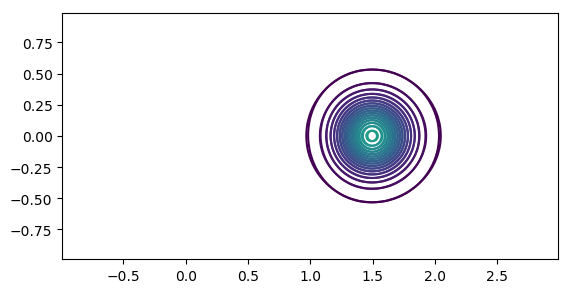

(-0.99, 2.99, -0.99, 0.99)

In [9]:
contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(0.01,1,30))
contour(x,y,wexact(s.t),linspace(0.01,1,30))
axis("scaled")

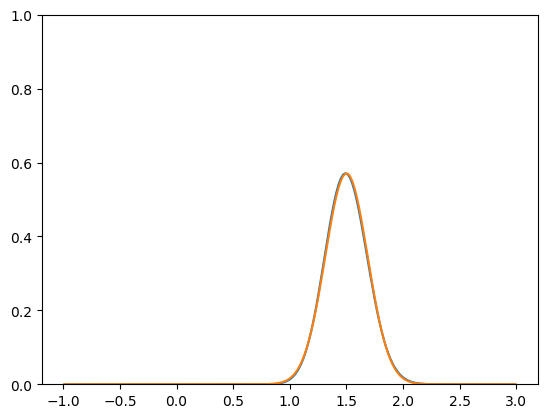

(0.0, 1.0)

In [10]:
plot(x[:,51],s.u[2:end-1,51]/Δx)
plot(x[:,51],wexact(s.t)[:,51])
ylim(0.0,1.0)